## Open notebook in:
| Colab                                 |  Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/transformers-the-definitive-guide/blob/master/CH06/CH06_Dit.ipynb)                                             | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com//github.com/Nicolepcx/transformers-the-definitive-guide/blob/main/CH06/CH06_Dit.ipynb)|             

# About this notebook


In this notebook, we will explore how to generate high-quality images using diffusion models, specifically using the `DiT-XL-2` model architecture from the paper: ["Scalable Diffusion Models with Transformers"](https://arxiv.org/abs/2212.09748).

The goal of this notebook is to guide you through the process of setting up the necessary environment, loading pre-trained models, and generating images based on specific class labels from the ImageNet dataset.

### What You Will Learn

1. **Setting Up the Diffusion Pipeline**: We will start by initializing the `DiTPipeline` with a pre-trained model and configuring it with the `DPMSolverMultistepScheduler` to enhance the sampling process.
  
2. **Working with ImageNet Labels**: You'll learn how to select specific class labels from the ImageNet dataset and use them as inputs to guide the image generation process.
  
3. **Model Loading and Configuration**: We will discuss how to load and configure the `DiT-XL-2` model along with a VAE (Variational Autoencoder) for the decoding process.

4. **Generating and Saving Images**: Finally, you will generate images based on the selected class labels and save these images for further analysis or display.


# Installs

In [1]:
! pip install diffusers===0.30.0 timm -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 849.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 66.1 MB/s eta 0:00:00


# Imports

In [2]:
!git clone https://github.com/facebookresearch/DiT.git

import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'

Cloning into 'DiT'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 102 (delta 56), reused 35 (delta 35), pack-reused 22 (from 1)
Receiving objects: 100% (102/102), 6.36 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
import requests
import os
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import download_model
from models import DiT_XL_2
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# Repo text labels
GIST_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"


 # Helper Functions


In [5]:
def download_and_parse_labels(url):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    label_mapping = eval(response.text)
    return {v: k for k, v in label_mapping.items()}

def names_to_labels(names, label_mapping):
    return [label_mapping[name] for name in names]

def get_label_ids():
    # Step 1: Download and parse the labels
    label_mapping = download_and_parse_labels(GIST_URL)

    # Step 2: Replace these with the actual class names you want to use
    class_names = [
        'Siberian husky',
        'tabby, tabby cat',
        'espresso',
        'guacamole'
    ]

    # Step 3: Convert names to labels
    class_labels = names_to_labels(class_names, label_mapping)
    # Step 4: Use these labels in your CLASS_LABELS
    print("Mapped class labels:", class_labels)
    return class_labels

In [6]:
# Constants
IMAGE_SIZE = 512
VAE_MODEL = "stabilityai/sd-vae-ft-ema"  # Options: "stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"
LATENT_SIZE = IMAGE_SIZE // 8
SEED = 42
NUM_SAMPLING_STEPS = 200
CFG_SCALE = 4.0
CLASS_LABELS = get_label_ids()
SAMPLES_PER_ROW = 4
OUTPUT_IMAGE = "sample.png"
MODEL_NAME = f"DiT-XL-2-{IMAGE_SIZE}x{IMAGE_SIZE}.pt"
print(MODEL_NAME)

Mapped class labels: [250, 281, 967, 924]
DiT-XL-2-512x512.pt


In [7]:
def load_models(device, MODEL_NAME):
    model = DiT_XL_2(input_size=LATENT_SIZE).to(device)
    state_dict = download_model(MODEL_NAME)
    model.load_state_dict(state_dict)
    model.eval()
    vae = AutoencoderKL.from_pretrained(VAE_MODEL).to(device)
    return model, vae

def generate_samples(model, vae, device):
    torch.manual_seed(SEED)

    # Create diffusion object
    diffusion = create_diffusion(str(NUM_SAMPLING_STEPS))

    # Create sampling noise
    n = len(CLASS_LABELS)
    z = torch.randn(n, 4, LATENT_SIZE, LATENT_SIZE, device=device)
    y = torch.tensor(CLASS_LABELS, device=device)

    # Setup classifier-free guidance
    z = torch.cat([z, z], 0)
    y_null = torch.tensor([1000] * n, device=device)
    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=CFG_SCALE) # classifier-free guidance scale

    # Sample images
    samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False,
        model_kwargs=model_kwargs, progress=True, device=device
    )
    samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
    samples = vae.decode(samples / 0.18215).sample
    return samples

def save_and_display_samples(samples):
    save_image(samples, OUTPUT_IMAGE, nrow=int(SAMPLES_PER_ROW),
               normalize=True, value_range=(-1, 1))
    samples = Image.open(OUTPUT_IMAGE)
    display(samples)

100%|██████████| 2704152777/2704152777 [00:08<00:00, 313589340.35it/s]


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/200 [00:00<?, ?it/s]

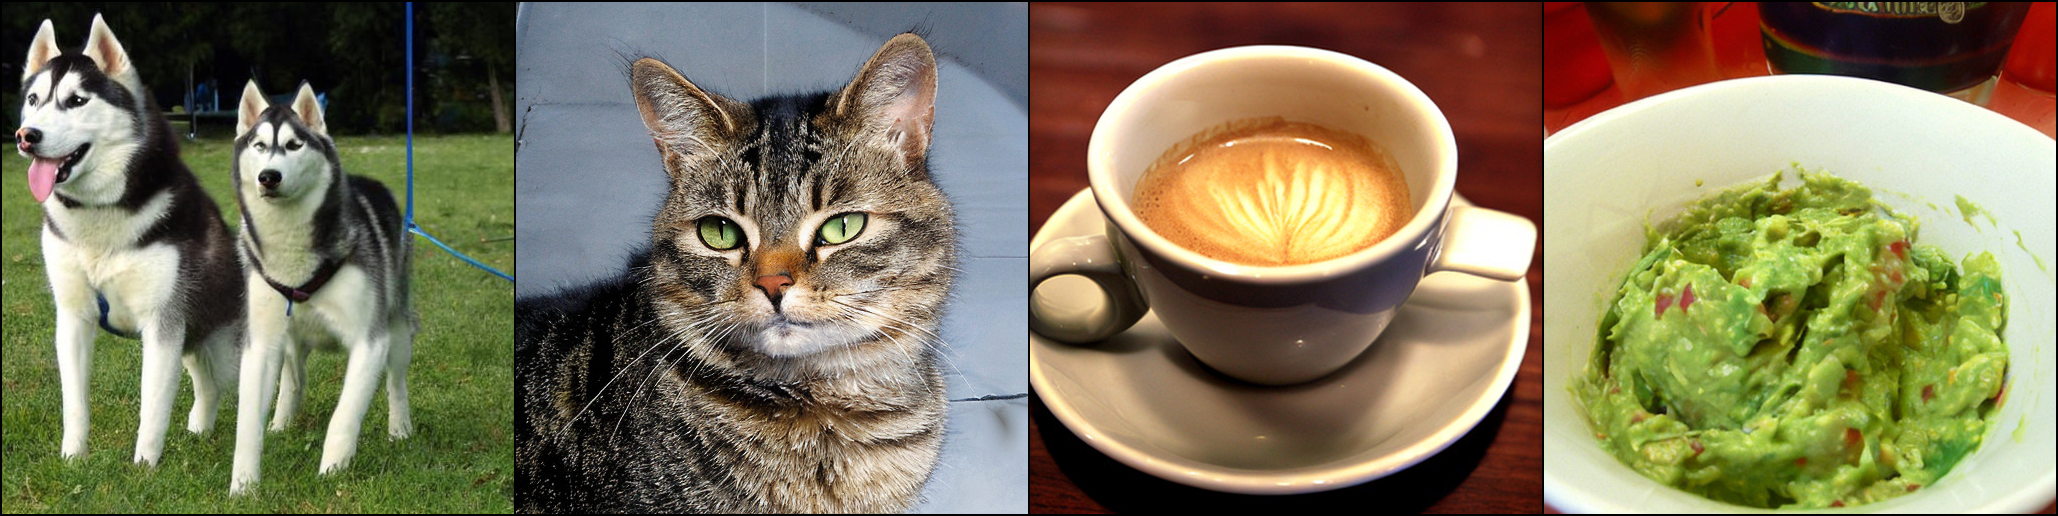

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and generate samples
model, vae = load_models(device, MODEL_NAME)
samples = generate_samples(model, vae, device)
save_and_display_samples(samples)
